In [1]:
from PIL import Image
image = Image.open('./pkm/all/001.png')

In [2]:
image.size

(400, 400)

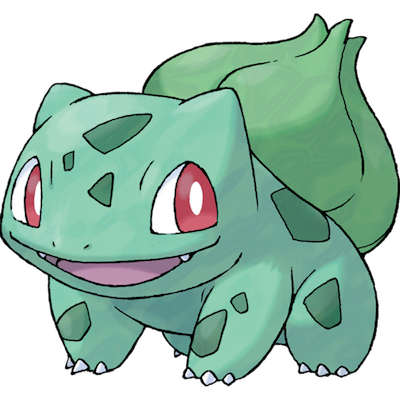

In [3]:
image

# Settings

In [4]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [5]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


# Dataset loading

In [6]:
dataset_name='pokemon'

In [7]:
images_dir = './pkm/'
validation_percentage = 0
valid_format = 'png'

In [8]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [9]:
imgs_list = create_image_lists(
    image_dir=images_dir, 
    validation_pct=validation_percentage, 
    valid_imgae_formats=valid_format
)

  DEBUG    | Looking for images in 'all'


  INFO     | 4 file found


  WARNING  | Folder has less than 20 images, which may cause issues.
..\..\..\training\generators\file_image_generator.py:91: UserWarning: Folder has less than 20 images, which may cause issues.
  warnings.warn(msg)


In [10]:
inputs_shape= image_size=(200, 200, 3)
batch_size = 4
latents_dim = 100
intermediate_dim = 100

In [11]:
training_generator, testing_generator = get_generators(
    images_list=imgs_list, 
    image_dir=images_dir, 
    image_size=image_size, 
    batch_size=batch_size, 
    class_mode=None
)

  INFO     | Found 4 training files


  INFO     | Found 0 validation files


In [12]:
from utils.augmentation.augmentor import operations, do_operation

In [13]:
str(operations[0]())

'Skew'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [15]:
from utils.reporting.ploting import append_images

In [16]:
batch = next(training_generator)
batch = next(training_generator)

In [17]:
image = [Image.fromarray((image*255).astype(np.uint8)) for image in batch][0]


In [18]:
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')

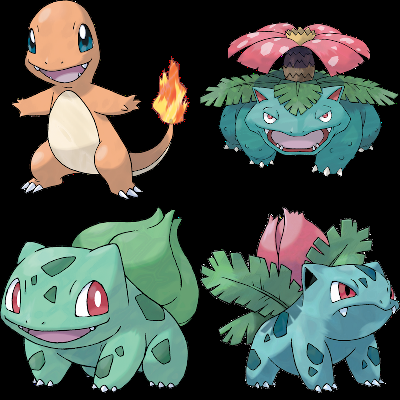

In [19]:
final

operation Skew ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


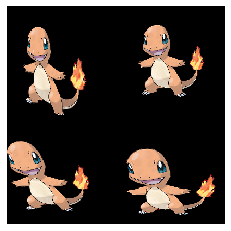

In [20]:
i = 0
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Distort ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


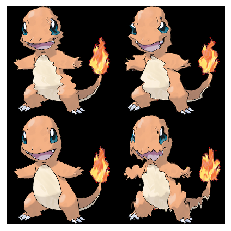

In [21]:
i = 1
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]    
    
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Rotate 214 ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


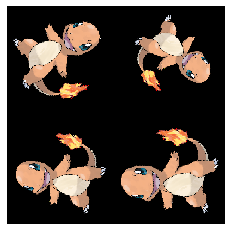

In [22]:
i = 2
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Shear ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


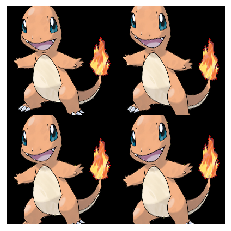

In [23]:
i = 3
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Zoom ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


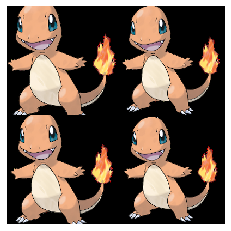

In [24]:
i = 4
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Colorize ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


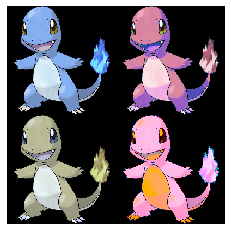

In [25]:
i = 5
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Skitch ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


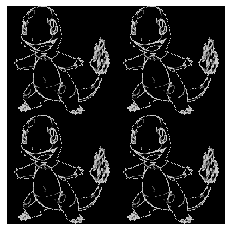

In [26]:
i = 6
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Flip ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


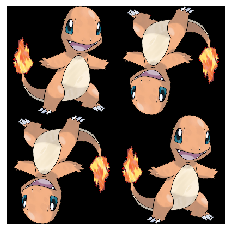

In [27]:
i = 7
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

In [28]:
import random

In [29]:
def batch_augmentor(batch, operation=None):
    if operation is None:
        rn = random.randint(0, len(operations)-1)
        print(operations[rn]())
        operation = operations[rn]()
    return np.array([do_operation(operation, image) for image in batch])


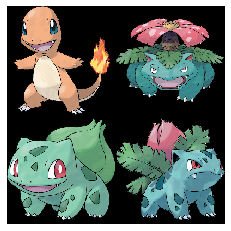

In [30]:
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Rotate 71


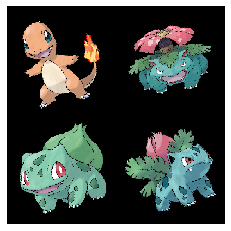

In [31]:
batch_augmented = batch_augmentor(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Skew


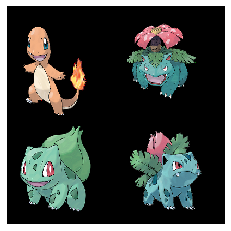

In [32]:
batch_augmented = batch_augmentor(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

In [33]:
def batch_augmentorx2(batch, operation1=None, operation2=None):
    options = list(range(len(operations)))
    if operation1 is None:
        rn = random.choice(options)
        print(operations[rn]())
        operation1 = operations[rn]()
    batch = np.array([do_operation(operation1, image) for image in batch])

    if operation2 is None:
        if rn in options:
            options.remove(rn)
        rn = random.choice(options)
        print(operations[rn]())
        operation2 = operations[rn]()
    return np.array([do_operation(operation2, image) for image in batch])

Shear
Skew


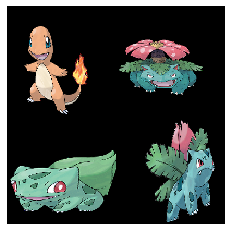

In [34]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Skitch
Shear


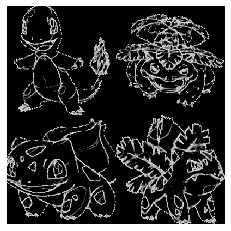

In [35]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Flip
Skew


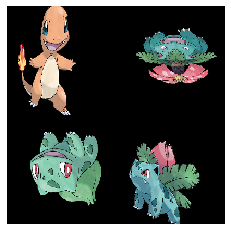

In [36]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Rotate 288
Distort


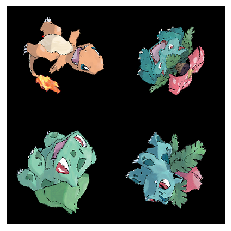

In [37]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

In [38]:
def batch_augmentorx3(batch, operation1=None, operation2=None, operation3=None):
    options = list(range(len(operations)))
    if operation1 is None:
        rn = random.choice(options)
        print(operations[rn]())
        operation1 = operations[rn]()
    batch = np.array([do_operation(operation1, image) for image in batch])

    if operation2 is None:
        if rn in options:
            options.remove(rn)
        rn = random.choice(options)
        print(operations[rn]())
        operation2 = operations[rn]()
    batch = np.array([do_operation(operation2, image) for image in batch])

    if operation3 is None:
        if rn in options:
            options.remove(rn)
        rn = random.choice(options)
        print(operations[rn]())
        operation3 = operations[rn]()
    return np.array([do_operation(operation3, image) for image in batch])

Rotate 165
Zoom
Colorize


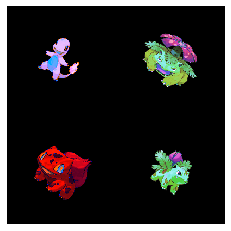

In [39]:
batch_augmented = batch_augmentorx3(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Flip
Skitch
Distort


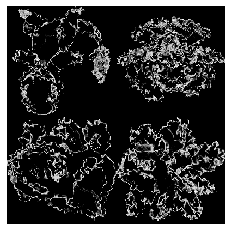

In [40]:
batch_augmented = batch_augmentorx3(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Colorize
Shear
Zoom


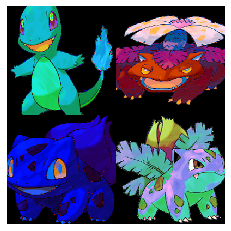

In [41]:
batch_augmented = batch_augmentorx3(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()